In [1]:
import matplotlib.pyplot as plt # We need this here only for closing the open windows
import numpy as np # we want to use some math...
from Modules import tictoc as t
from scipy.optimize import minimize
from numdifftools import Jacobian, Hessian
from scipy.interpolate import interp1d

# for nice(r) potting in the notebook
%matplotlib inline 

##  If not in Jupyter: close all open plots (otherwise you will get tons of them after some time...)
# plt.close("all")

# Some house holding: 
#  Higher resolution for figures:
%config InlineBackend.figure_format = 'retina' # (doubles the plot dpi)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# for interactive graphing: 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# load data from saved files
particles_frequency_001 = np.load('./images/dataset/001_particles.npy')
diameter_frequency_001 = np.load('./images/dataset/001_diameter.npy')

In [3]:
# load data from saved files
particles_frequency_006 = np.load('./images/dataset/006_particles.npy')
diameter_frequency_006 = np.load('./images/dataset/006_diameter.npy')

In [4]:
# combine data from both images
particles_frequency = np.concatenate((particles_frequency_001,particles_frequency_006))
diameter_frequency = np.concatenate((diameter_frequency_001,diameter_frequency_006))

In [5]:
from matplotlib.ticker import MaxNLocator
import collections

def plot_result(result, xlabel='x', ylabel='y'):
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel, color='tab:blue')
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[0].axvline(np.mean(result), color='k', linestyle='--', linewidth=3)
    ax[0].axvline(np.median(result), color='b', linestyle='-', linewidth=3)
    ax[0].text(np.mean(result), np.amax(result), 'Mean: {:.2f}'.format(np.mean(result)))
    ax[0].text(np.median(result), np.amax(result)*0.7, 'Median: {:.2f}'.format(np.median(result)))
    
#     np.amax(np.array(list()))
#     counts, bins = np.histogram(result, range=(np.array(list())))
#     ax[0].hist(bins[:-1], bins, weights=counts)
    hist = collections.Counter(result)
    ax[0].bar(hist.keys(),hist.values(),width=1)

    
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel, color='tab:blue')
    ax[1].boxplot(result, vert=False)
    
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel(ylabel, color='tab:blue')
    ax[2].violinplot(result, vert=False, showmeans=True,)
    plt.show()

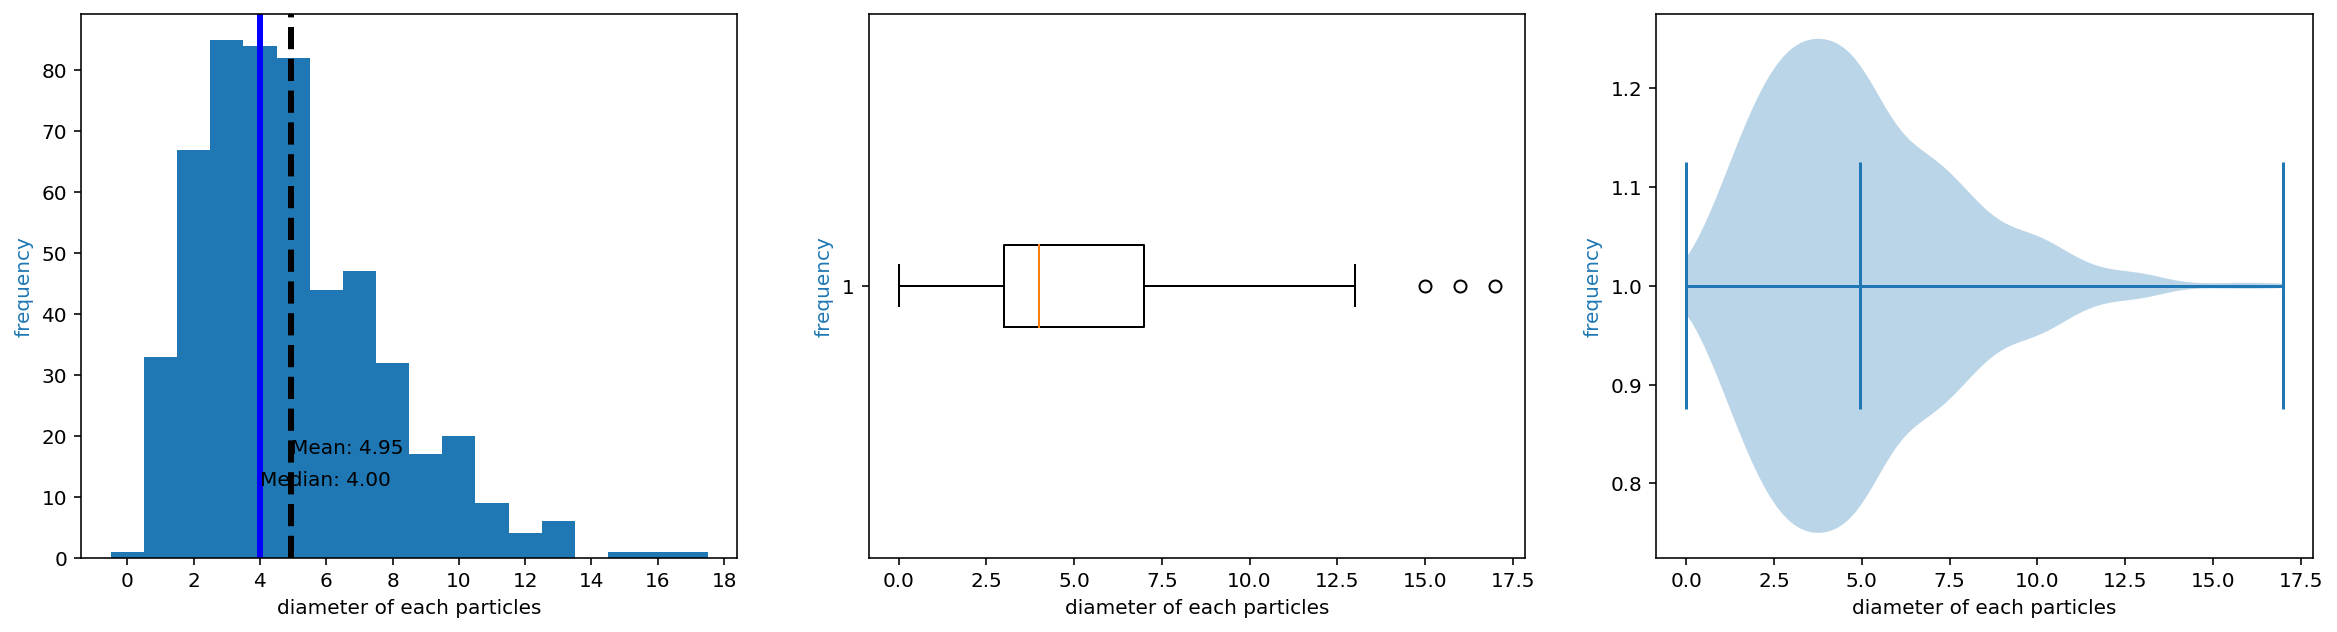

In [6]:
plot_result(particles_frequency, xlabel='diameter of each particles', ylabel='frequency')

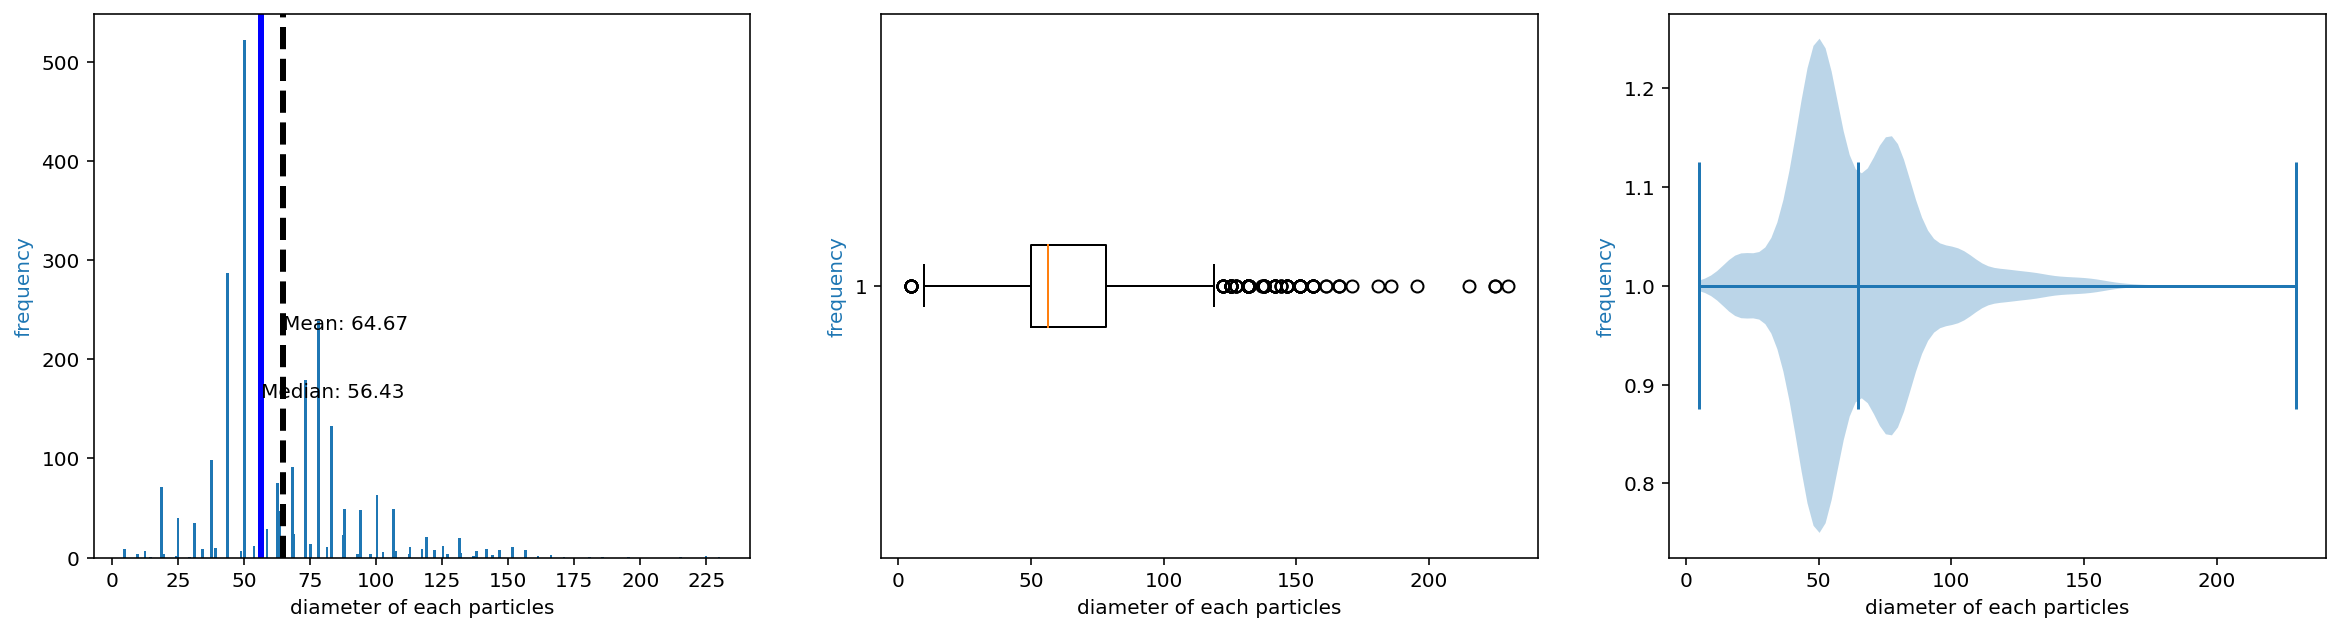

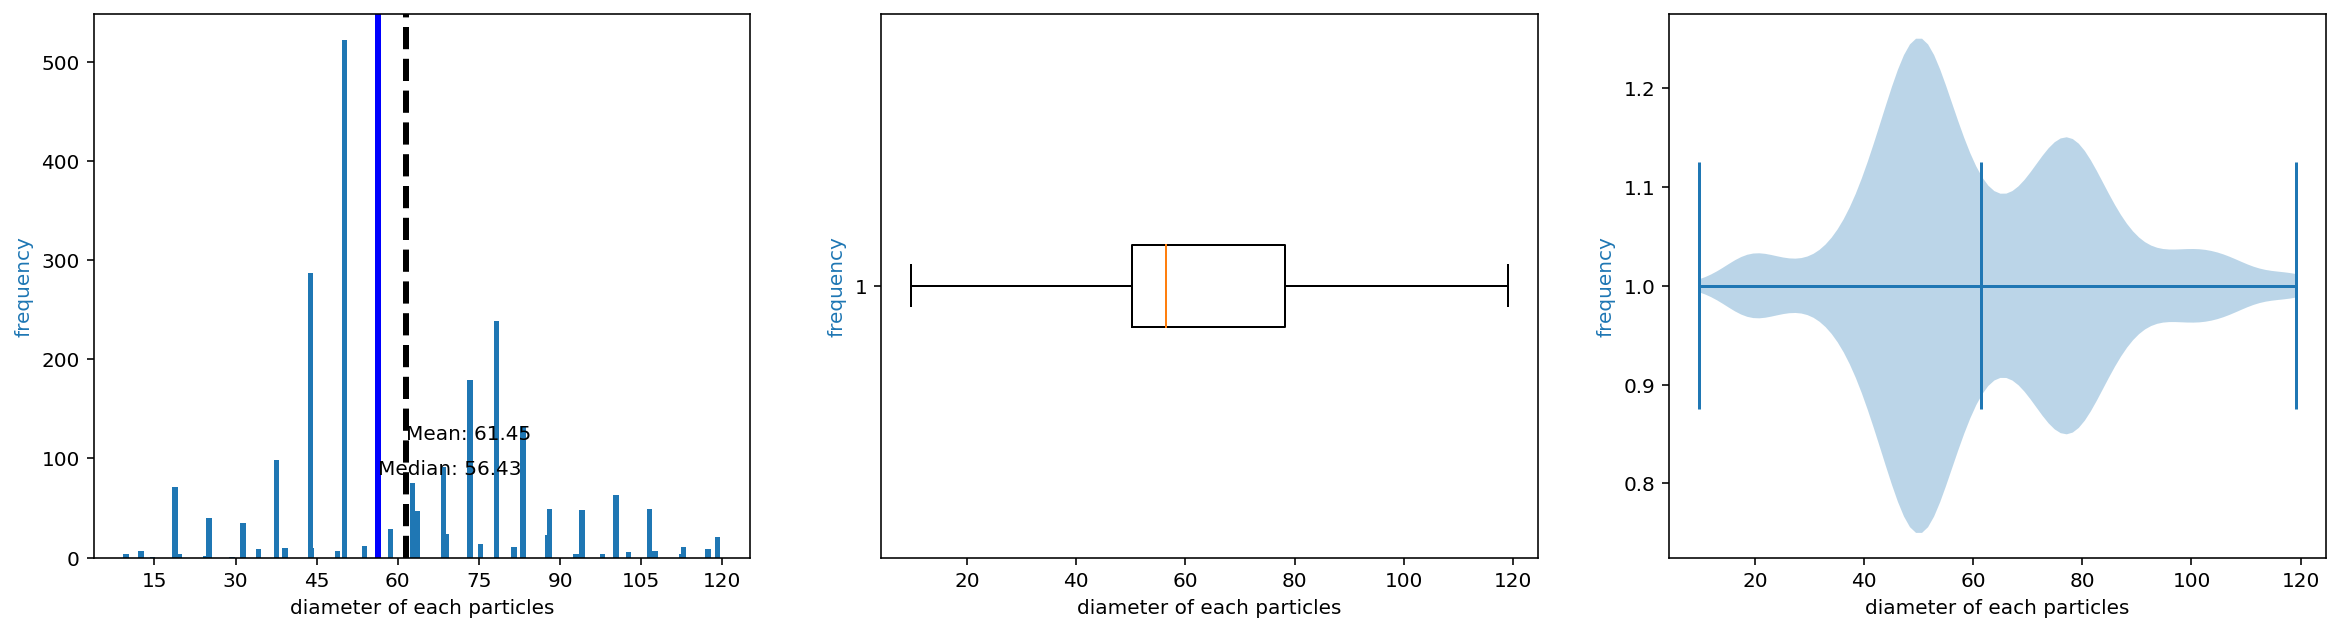

In [7]:
# remove outliers based on the boxplot
diameter_frequency_1 = diameter_frequency[(diameter_frequency >= 5) & (diameter_frequency <= 120)]
plot_result(diameter_frequency, xlabel='diameter of each particles', ylabel='frequency')
plot_result(diameter_frequency_1, xlabel='diameter of each particles', ylabel='frequency')

In [8]:
def statistic(result):
#     print(result)
    print(np.mean(result)) # sum of all the entries divided by the number of entries / the average value 
    print(np.median(result)) # the middle point of the number of entries
    print(np.var(result)) # measures how far a set of numbers is spread out from their average value
    print(np.std(result)) # a measure of the amount of variation or dispersion of a set of values.

In [9]:
statistic(particles_frequency)

4.949438202247191
4.0
7.75212515254808
2.784263843917828


In [10]:
statistic(diameter_frequency)

64.6696869704177
56.426332288401255
724.4480997200399
26.915573553614642


In [11]:
statistic(diameter_frequency_1)

61.45099600799012
56.426332288401255
445.73656404124483
21.112474133583795


### Extract data
#### X1: number of particles of each cluster
#### X2: diameter of each particle

In [12]:
import collections 

std1 = np.std(particles_frequency)
mean1 = np.mean(particles_frequency)

hist1 = collections.Counter(particles_frequency)
sorted_hist1 = {i: hist1[i] for i in sorted(hist1)}
X1 = np.array(list(sorted_hist1.keys()))
Y1 = np.array(list(sorted_hist1.values()))
# print(X1)
# print(Y1)

In [13]:
std2 = np.std(diameter_frequency_1)
mean2 = np.mean(diameter_frequency_1)

hist2 = collections.Counter(diameter_frequency_1)
sorted_hist2 = {i: hist2[i] for i in sorted(hist2)}
X2 = np.array(list(sorted_hist2.keys()))
Y2 = np.array(list(sorted_hist2.values()))
# print(X2)
# print(Y2)

In [14]:
from sympy import *
A, B = symbols("A B")

### single gaussian peak
we use gaussian curve with only one peak to find the fitting function

$$ f(x_n) = y_1*\exp{\left(-\frac{(x_n-x_1)^2}{2\sigma_1^2}\right)} $$
with the peak height $y_1$, the center position $x_1$ and the peak width $\sigma_1$

In [15]:
std_sg = "global"
mean_sg = "global"
def sg_func(A, B, x):
    return A*np.exp((-1/2)*((x-mean_sg)/std_sg)**2) + B

def sg_residual(A, B, x, y):
    return y - sg_func(A, B, x)

def sg_leastsq(A, B, x, y):
    return sum(sg_residual(A, B, x, y)**2)

In [16]:
def plot_single_curve(xnew, ynew, measuredX, measuredY, data, xlabel, ylabel):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
    ax.scatter(measuredX, measuredY, marker= 'o')
    ax.plot(measuredX,sg_func(xnew, ynew, measuredX))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='tab:blue')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.axvline(np.mean(data), color='k', linestyle='--', linewidth=3)
    ax.axvline(np.median(data), color='b', linestyle='-', linewidth=3)
    ax.text(np.mean(data), np.amax(data), 'Mean: {:.2f}'.format(np.mean(data)))
    ax.text(np.median(data), np.amax(data)*0.7, 'Median: {:.2f}'.format(np.median(data)))

    hist = collections.Counter(data)
    ax.bar(hist.keys(),hist.values(),width=0.1)

Fitting function for number of particles of each cluster (particles_frequency)

In [17]:
std_sg = std1
mean_sg = mean1

In [18]:
# Newton_method
f = sg_leastsq(A, B, X1, Y1)
grad_f = Matrix([f]).jacobian([A, B])
grad_ff=hessian(f,[A,B]) ## Hessian  

In [19]:
X= np.array([[84],[3]]) ## Intial guess x_n
xk=X[0][0] ## Intial guess x_n
yk=X[1][0] ## Intial guess x_n
epsilon = 1e-6 # Pick the tolerance 
count = 0 # for the number of iteration 
nMax=100 # maximum number of iteration

In [20]:
while count < nMax:
    count += 1 # count the loop iterations...
    df = transpose(grad_f.subs({A:xk, B:yk}))
    dff = grad_ff.subs({A:xk, B:yk})
    H=np.array([[dff[0,0],dff[0,1]],[dff[1,0],dff[1,1]]])
    H=H.astype(float)
    xn=np.array([[xk],[yk]])
    X=X-np.linalg.inv(H)*df
    Xn=np.array(X)
    xk=Xn[0][0]
    yk=Xn[1][0]
    #error=np.sqrt((xk-xn[0][0])**2+(yk-xn[1][0])**2)
#     print('Step: %i-- new guess x: %e-- new guess y: %e' %(count,xk,yk))

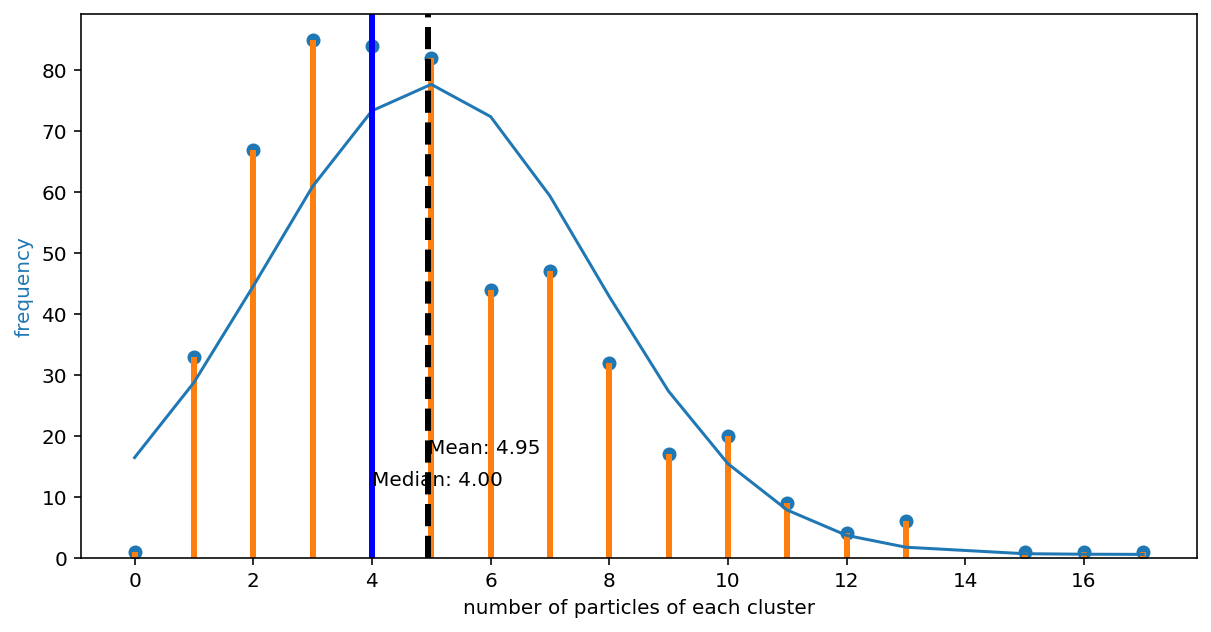

In [21]:
plot_single_curve(xk, yk, X1, Y1, particles_frequency, 'number of particles of each cluster', 'frequency')

As we see that, the fitting function with only one peak is inaccuracy because it cannot cover most of data points

Fitting function for diameter of each paricle (diameter_frequency)

In [22]:
std_sg = std2
mean_sg = mean2

In [23]:
f = sg_leastsq(A, B, X2, Y2)
grad_f = Matrix([f]).jacobian([A, B])
grad_ff=hessian(f,[A,B]) ## Hessian  

In [24]:
X= np.array([[520],[50]]) ## Intial guess x_n
xk=X[0][0] ## Intial guess x_n
yk=X[1][0] ## Intial guess x_n
# print(X[1][0])
epsilon = 1e-6 # Pick the tolerance 
count = 0 # for the number of iteration 
nMax=30 # maximum number of iteration

In [25]:
while count < nMax:
    count += 1 # count the loop iterations...
    df = transpose(grad_f.subs({A:xk, B:yk}))
    dff = grad_ff.subs({A:xk, B:yk})
    H=np.array([[dff[0,0],dff[0,1]],[dff[1,0],dff[1,1]]])
    H=H.astype(float)
    xn=np.array([[xk],[yk]])
    X=X-np.linalg.inv(H)*df
    Xn=np.array(X)
    xk=Xn[0][0]
    yk=Xn[1][0]
    #error=np.sqrt((xk-xn[0][0])**2+(yk-xn[1][0])**2)
#     print('Step: %i-- new guess x: %e-- new guess y: %e' %(count,xk,yk))

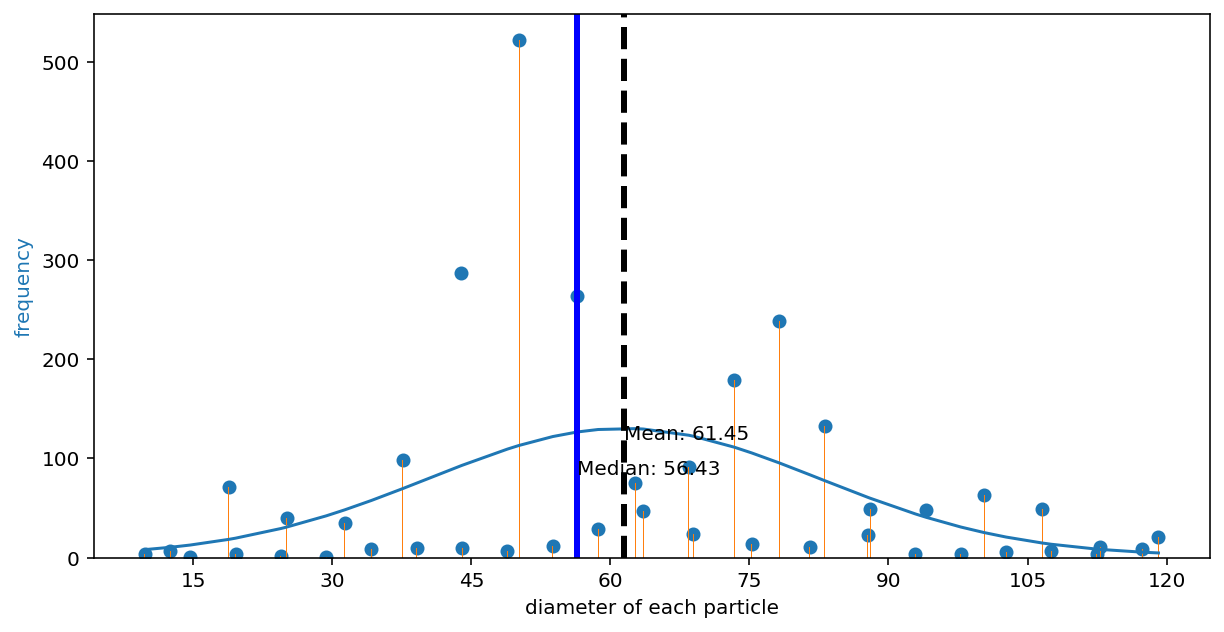

In [26]:
plot_single_curve(xk, yk, X2, Y2, diameter_frequency_1, 'diameter of each particle', 'frequency')

In this part, we use both sequence of Lorentzian curves and that of Gaussian curve with Newton_method and Nelder-Mead to get the best result.
Because the least square error function is unconstraint, we will use the optimisation algorithms for unconstraint function. Moreover, we need to find the local peak of the least square function.

### Sequence of Gaussian

$$ f(x_n) = \sum_{k=1}^{K} y_k*\exp{\left(-\frac{(x_n-x_k)^2}{2\sigma_k^2}\right)} $$
with the peak height $y_k$, the center position $x_k$ and the peak width $\sigma_k$

In [27]:
gresidualX = "global"
gresidualY = "global"
K = "global"
def gaussian_func(x, p):
    k1 = k2 =k3 =k4 = 0
    
    if K >= 1:
        cen1=p[0]
        amp1=p[1]
        sigma1=p[2]
        k1 = amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))
    if K >= 2:
        cen2=p[3]
        amp2=p[4]
        sigma2=p[5]
        k2 = amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))
    if K >= 3:
        cen3=p[6]
        amp3=p[7]
        sigma3=p[8]
        k3 = amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))
    if K >= 4:
        cen4=p[9]
        amp4=p[10]
        sigma4=p[11]
        k4 = amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))
    return k1 + k2 + k3 + k4

def gaussian_residual(p):
    return gresidualY - gaussian_func(gresidualX, p)
# least square
def gaussian_leastsq(p):
    return sum(gaussian_residual(p)**2)

In [28]:
# jacobian of calc_error function
def gaus_jac(p):
    return Jacobian(lambda p: gaussian_leastsq(p))(p).ravel()
# hessian of calc_error function
def gaus_hess(p):
    return Hessian(lambda p: gaussian_leastsq(p))(p) 

In [29]:
def plot_gaussian_fitting_func(args, measuredX, measuredY, data, xlabel, ylabel):
    y = gaussian_func(measuredX, args)
    
    xnew = np.linspace(measuredX.min(), measuredX.max(), 100) # generate more x points based on the measuredX
    ynew = interp1d(measuredX, y, kind='quadratic') # get new y-value from generated x

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
    ax.scatter(measuredX, measuredY, marker= 'o')
    ax.plot(xnew, ynew(xnew))
    # draw grid for checking and finding the initial points
    ax.set_xticks(np.arange(0, np.amax(measuredX), 5))
    ax.set_yticks(np.arange(0, np.amax(measuredY), np.amax(measuredY)/10))
    plt.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='tab:blue')
    # format the value of XY axis to integer
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # draw mean and median lines
    ax.axvline(np.mean(data), color='k', linestyle='--', linewidth=3)
    ax.axvline(np.median(data), color='b', linestyle='-', linewidth=3)
    ax.text(np.mean(data), np.amax(particles_frequency), 'Mean: {:.2f}'.format(np.mean(data)))
    ax.text(np.median(data), np.amax(particles_frequency)*0.5, 'Median: {:.2f}'.format(np.median(data)))
#     hist = collections.Counter(data)
#     ax.bar(hist.keys(),hist.values(),width=0.2)

In [30]:
def single_gaussian_func(x, p):
    cen1 = p[0]
    amp1 = p[1]
    sigma1 = p[2]
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

In [31]:
def plot_fill_test(result):
    fig, ax = plt.subplots()
    if K >= 1:
        param_peak1 = result[0:3]
        peak1 = single_gaussian_func(gresidualX, param_peak1)
        ax.plot(gresidualX, peak1 , "g")
        ax.fill_between(gresidualX, peak1.min(), peak1, facecolor="green", alpha=0.5)
    if K >= 2:
        param_peak2 = result[3:6]
        peak2 = single_gaussian_func(gresidualX, param_peak2)
        ax.plot(gresidualX, peak2 , "r")
        ax.fill_between(gresidualX, peak2.min(), peak2, facecolor="red", alpha=0.5)
    if K >= 3:
        param_peak3 = result[6:9]
        peak3 = single_gaussian_func(gresidualX, param_peak3)
        ax.plot(gresidualX, peak3 , "y")
        ax.fill_between(gresidualX, peak3.min(), peak3, facecolor="yellow", alpha=0.5)
    if K >= 4:
        param_peak4 = result[9:12]
        peak4 = single_gaussian_func(gresidualX, param_peak4)
        ax.plot(gresidualX, peak4 , "b")
        ax.fill_between(gresidualX, peak4.min(), peak4, facecolor="blue", alpha=0.5)

In [32]:
K = 3
gresidualX = X1
gresidualY = Y1
if K == 1:
    P0=np.array([
            3,84,1
            ])
elif K == 2:
    P0=np.array([
            3,84,1,
            7,45,1
            ])
elif K == 3:
    P0=np.array([
            3,84,1,
            7,45,1,
            10,20,1
            ])
elif K == 4:
    P0=np.array([
            3,84,1,
            7,45,1,
            10,20,1,
            13,8,1
            ])

In [33]:
NMResedual = minimize(gaussian_leastsq, P0, method='Nelder-Mead' ,tol=1e-1,options={'disp': True})
print(NMResedual.x)

Optimization terminated successfully.
         Current function value: 439.659775
         Iterations: 474
         Function evaluations: 674
[ 2.98720615 65.21582712  1.47308237  5.45598565 46.03951723  2.05171628
  9.58374828 11.79195975  2.09315608]


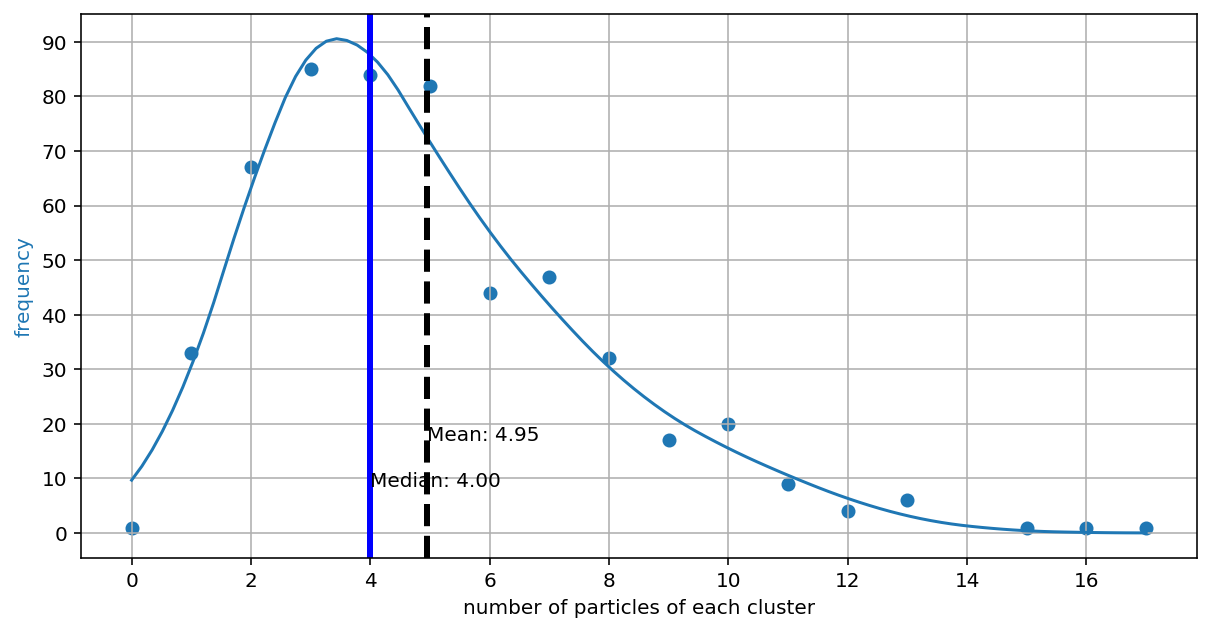

In [34]:
plot_gaussian_fitting_func(NMResedual.x, gresidualX, gresidualY, particles_frequency,'number of particles of each cluster','frequency')

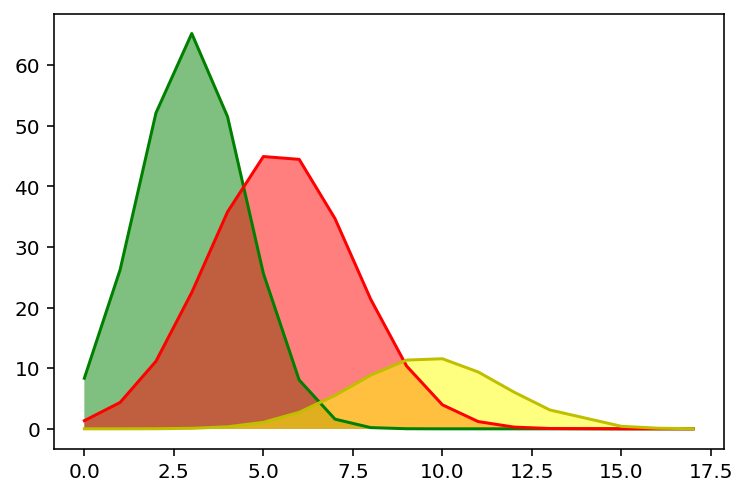

In [35]:
plot_fill_test(NMResedual.x)

In [36]:
NTResedual = minimize(gaussian_leastsq, P0, method='Newton-CG',jac=gaus_jac, hess=gaus_hess ,options={'disp': True})

Optimization terminated successfully.
         Current function value: 424.566049
         Iterations: 40
         Function evaluations: 70
         Gradient evaluations: 109
         Hessian evaluations: 40


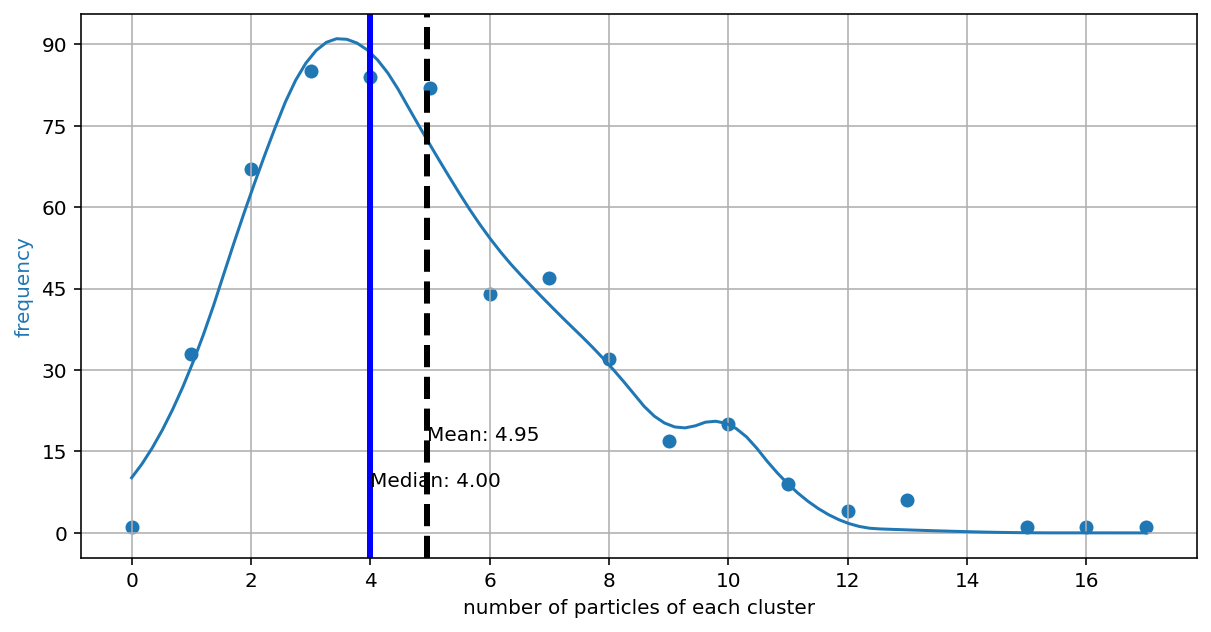

In [37]:
plot_gaussian_fitting_func(NTResedual.x, gresidualX, gresidualY, particles_frequency,'number of particles of each cluster','frequency')

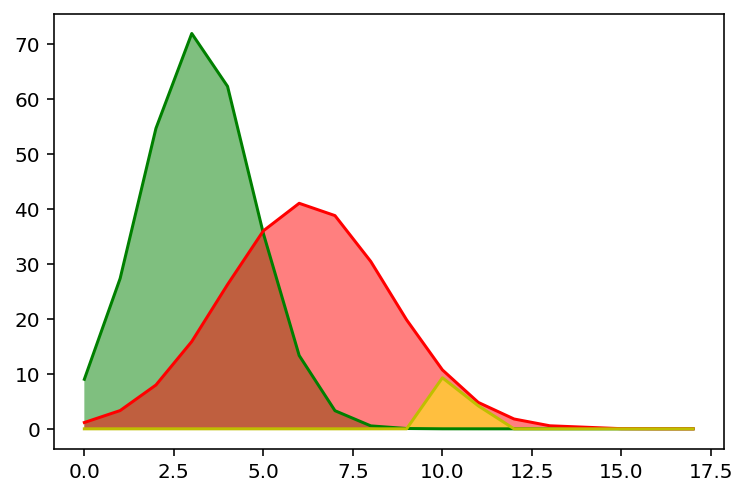

In [38]:
plot_fill_test(NTResedual.x)

In [39]:
K = 4
gresidualX = X2
gresidualY = Y2
if K == 1:
    P0=np.array([
             50,520,5,
            ])
elif K == 2:
    P0=np.array([
             50,520,5,
             78,239,5,
            ])
elif K == 3:
    P0=np.array([
             18,71,3,
             50,520,5,
             78,239,5,
            ])
elif K == 4:
    P0=np.array([
             18,71,3,
             50,520,5,
             78,239,5,
             100,63,3
            ])

In [40]:
NMResedual = minimize(gaussian_leastsq, P0, method='Nelder-Mead' ,tol=1e-1,options={'disp': True})
print(NMResedual.x)

Optimization terminated successfully.
         Current function value: 284278.732312
         Iterations: 1225
         Function evaluations: 1703
[ 19.91253905  33.74649127   3.6189483   49.95744803 221.57877024
   6.542515    77.02624597 131.52739078   6.8225329  101.91580065
  36.68259926   4.45880078]


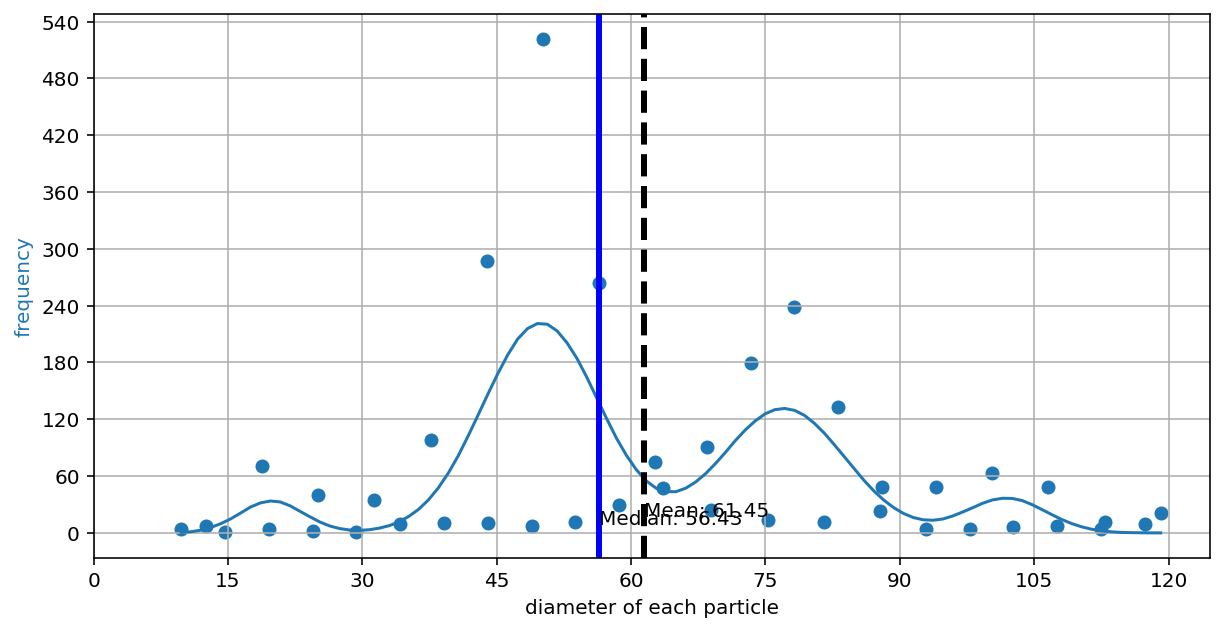

In [41]:
plot_gaussian_fitting_func(NMResedual.x, gresidualX, gresidualY, diameter_frequency_1,'diameter of each particle','frequency')

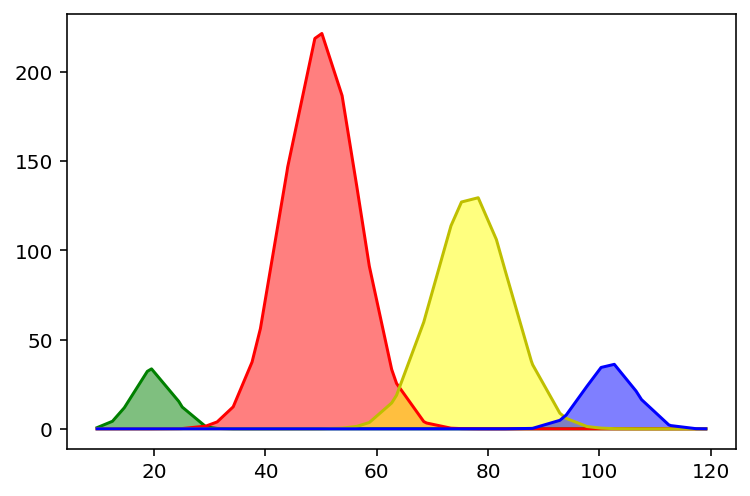

In [42]:
plot_fill_test(NMResedual.x)

In [43]:
NTResedual = minimize(gaussian_leastsq, P0, method='Newton-CG',jac=gaus_jac, hess=gaus_hess ,options={'disp': True})

Optimization terminated successfully.
         Current function value: 137742.011128
         Iterations: 39
         Function evaluations: 84
         Gradient evaluations: 122
         Hessian evaluations: 39


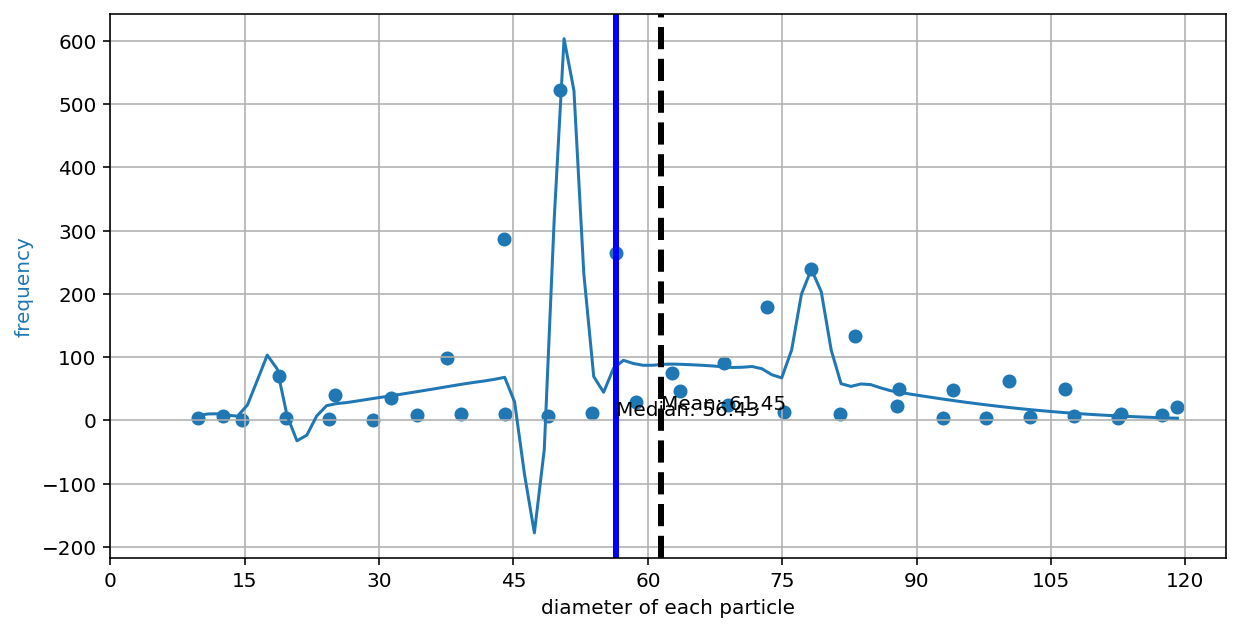

In [44]:
plot_gaussian_fitting_func(NTResedual.x, gresidualX, gresidualY, diameter_frequency_1,'diameter of each particle','frequency')

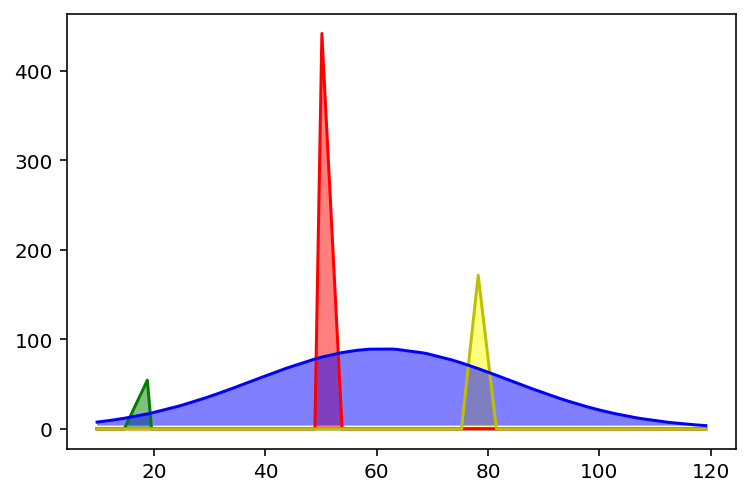

In [45]:
plot_fill_test(NTResedual.x)

# Only for comparing between Gaussian and Lorentzians curves

### Sequence of Lorentzians

Particle

In [46]:
residualX = "global"
residualY = "global"
def lorent_func(x, p):
    k1 = k2 = k3 = k4 = 0
    if K >= 1:
        cen1 = p[0]
        amp1 = p[1]
        wid1 = p[2]
        k1 = (amp1*wid1**2/((x-cen1)**2+wid1**2))
    if K >= 2:
        cen2 = p[3]
        amp2 = p[4]
        wid2 = p[5]
        k2 = (amp2*wid2**2/((x-cen2)**2+wid2**2))
    if K >= 3:
        cen3 = p[6]
        amp3 = p[7]
        wid3 = p[8]
        k3 = (amp3*wid3**2/((x-cen3)**2+wid3**2))
    if K >= 4:
        cen4 = p[9]
        amp4 = p[10]
        wid4 = p[11]
        k4 = (amp4*wid4**2/((x-cen4)**2+wid4**2))
    return  k1 + k2 + k3 + k4
            
def lorent_residual(p):
    return residualY - lorent_func(residualX, p)
# least square
def lorent_leastsq(p):
    return sum(lorent_residual(p)**2)

In [47]:
# jacobian of calc_error function
def lorent_jac(p):
    return Jacobian(lambda p: lorent_leastsq(p))(p).ravel()
# hessian of calc_error function
def lorent_hess(p):
    return Hessian(lambda p: lorent_leastsq(p))(p) 

In [48]:
def plot_lorent_fitting_func(args, measuredX, measuredY, data, xlabel, ylabel):
    y = lorent_func(measuredX, args)
    # smoothing the graph
    xnew = np.linspace(measuredX.min(), measuredX.max(), 100) # generate more x points based on the measuredX
    ynew = interp1d(measuredX, y, kind='quadratic') # get new y-value from generated x

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,5))
    ax.scatter(measuredX, measuredY, marker= 'o')
    ax.plot(xnew, ynew(xnew))
    # draw grid for checking and finding the initial points
    ax.set_xticks(np.arange(0, np.amax(measuredX), 5))
    ax.set_yticks(np.arange(0, np.amax(measuredY), np.amax(measuredY)/10))
    plt.grid()
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, color='tab:blue')
    # format the value of XY axis to integer
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # draw the mean and median lines
    ax.axvline(np.mean(data), color='k', linestyle='--', linewidth=3)
    ax.axvline(np.median(data), color='b', linestyle='-', linewidth=3)
    ax.text(np.mean(data), np.amax(particles_frequency), 'Mean: {:.2f}'.format(np.mean(data)))
    ax.text(np.median(data), np.amax(particles_frequency)*0.5, 'Median: {:.2f}'.format(np.median(data)))
#     hist = collections.Counter(data)
#     ax.bar(hist.keys(),hist.values(),width=0.2)

In [49]:
def single_lorent_func(x, p):
    cen1 = p[0]
    amp1 = p[1]
    wid1 = p[2]
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))

In [50]:
def plot_lorent_fill_test(result):
    fig, ax = plt.subplots()
    if K >= 1:
        param_peak1 = result[0:3]
        peak1 = single_lorent_func(residualX, param_peak1)
        ax.plot(residualX, peak1 , "g")
        ax.fill_between(residualX, peak1.min(), peak1, facecolor="green", alpha=0.5)
    if K >= 2:
        param_peak2 = result[3:6]
        peak2 = single_lorent_func(residualX, param_peak2)
        ax.plot(residualX, peak2 , "r")
        ax.fill_between(residualX, peak2.min(), peak2, facecolor="red", alpha=0.5)
    if K >= 3:
        param_peak3 = result[6:9]
        peak3 = single_lorent_func(residualX, param_peak3)
        ax.plot(residualX, peak3 , "y")
        ax.fill_between(residualX, peak3.min(), peak3, facecolor="yellow", alpha=0.5)
    if K >= 4:
        param_peak4 = result[9:12]
        peak4 = single_lorent_func(residualX, param_peak4)
        ax.plot(residualX, peak4 , "b")
        ax.fill_between(residualX, peak4.min(), peak4, facecolor="blue", alpha=0.5)

In [51]:
K = 3
residualX = X1
residualY = Y1
if K == 1:
    P0=np.array([
            3,84,1
            ])
elif K == 2:
    P0=np.array([
            3,84,1,
            7,45,1
            ])
elif K == 3:
    P0=np.array([
            3,84,1,
            7,45,1,
            10,20,1
            ])
elif K == 4:
    P0=np.array([
            3,84,1,
            7,45,1,
            10,20,1,
            13,8,1
            ])
NMResedual = minimize(lorent_leastsq, P0, method='Nelder-Mead' , tol=1e-1, options={'disp': True})
print(NMResedual.x)

Optimization terminated successfully.
         Current function value: 363.185527
         Iterations: 710
         Function evaluations: 1015
[ 2.50290035 74.61955084  0.75521169  4.52707107 75.91366334  1.2087377
  7.43859466 24.13097489  1.84432839]


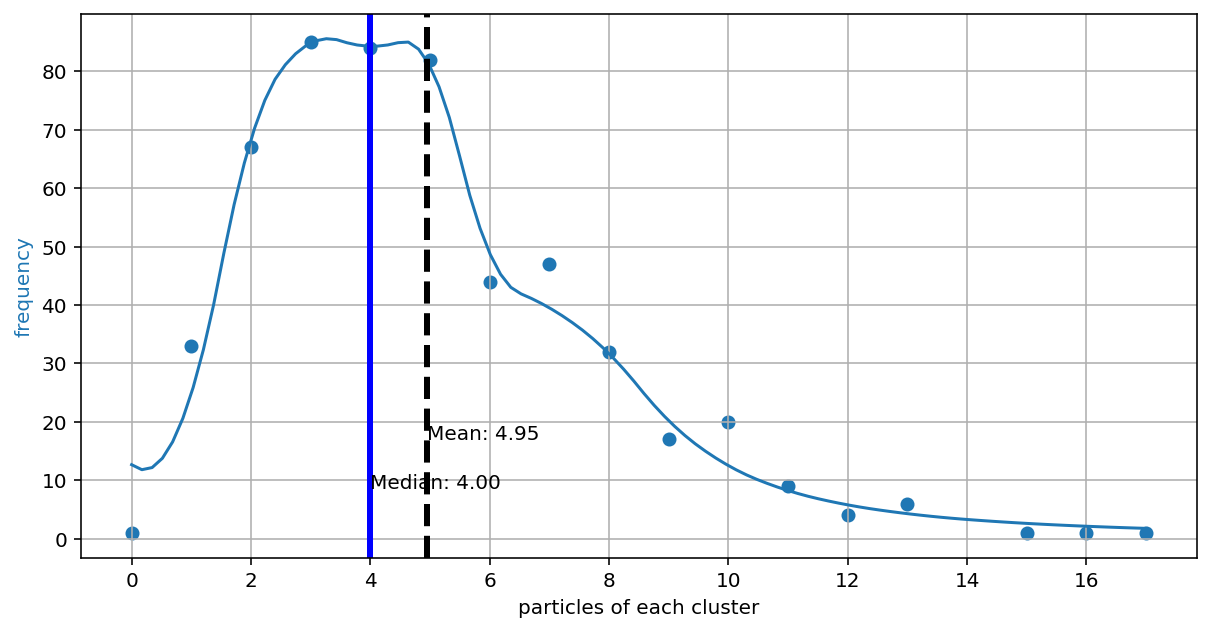

In [52]:
plot_lorent_fitting_func(NMResedual.x, X1, Y1, particles_frequency,'particles of each cluster','frequency')

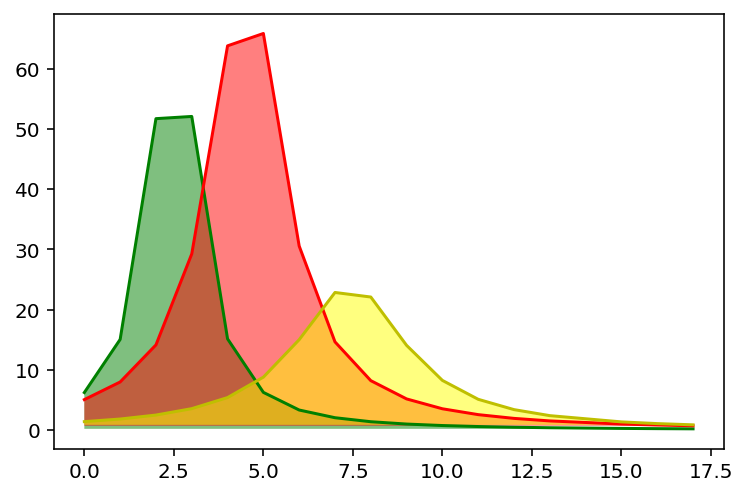

In [53]:
plot_lorent_fill_test(NMResedual.x)

In [54]:
NTResedual = minimize(lorent_leastsq, P0, method='Newton-CG',jac=lorent_jac, hess=lorent_hess ,options={'disp': True})

Optimization terminated successfully.
         Current function value: 892.119374
         Iterations: 1133
         Function evaluations: 1213
         Gradient evaluations: 2345
         Hessian evaluations: 1133


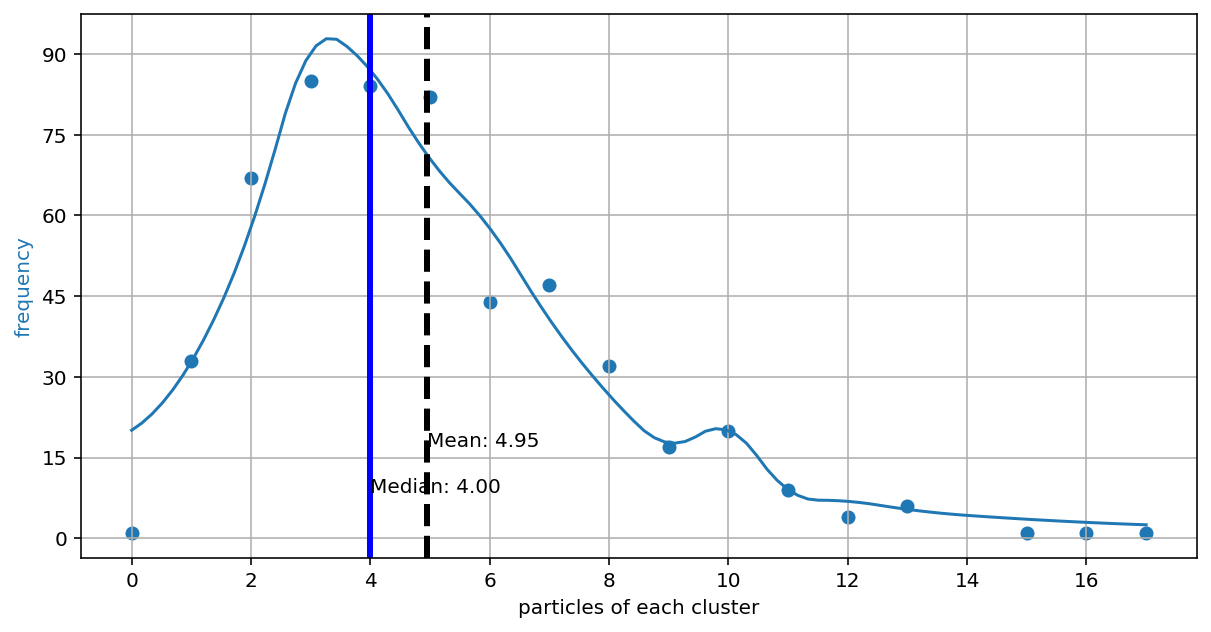

In [55]:
plot_lorent_fitting_func(NTResedual.x, X1, Y1, particles_frequency,'particles of each cluster','frequency')

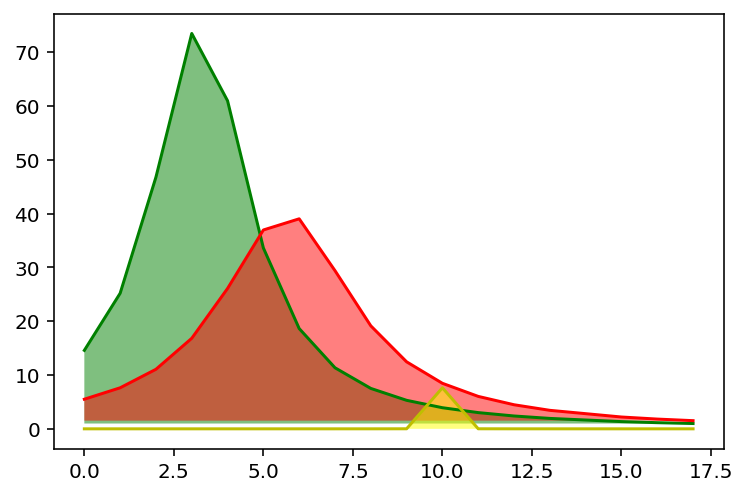

In [56]:
plot_lorent_fill_test(NTResedual.x)

In [57]:
# from scipy.optimize.linesearch import line_search_armijo

# start_point =np.array([3,84,0.1,
# #              5,80,0.1,
#              7,45,0.1,
#              10,20,0.1])

# line_search_armijo(calc_error, opti_jac(start_point), start_point, -opti_jac(start_point), 
#                    old_fval=calc_error(start_point), alpha0=0.001)

Diameter

In [58]:
K = 4
residualX = X2
residualY = Y2
if K == 1:
    P0=np.array([
             50,520,5,
            ])
elif K == 2:
    P0=np.array([
             50,520,5,
             78,239,5,
            ])
elif K == 3:
    P0=np.array([
             18,71,3,
             50,520,5,
             78,239,5,
            ])
elif K == 4:
    P0=np.array([
             18,71,3,
             50,520,5,
             78,239,5,
             100,63,3
            ])
NMResedual = minimize(lorent_leastsq, P0, method='Nelder-Mead' ,tol=1e-1,options={'disp': True})
print(NMResedual.x)

Optimization terminated successfully.
         Current function value: 169986.007603
         Iterations: 1678
         Function evaluations: 2350
[-7.56301479e+01 -4.81230990e+02  1.53254177e+01  5.01568990e+01
  2.28667567e+03  7.77692466e-05  6.22266354e+01  1.03589097e+02
  2.94258819e+01  5.26651986e+02 -2.39644078e+02 -7.84340749e+00]


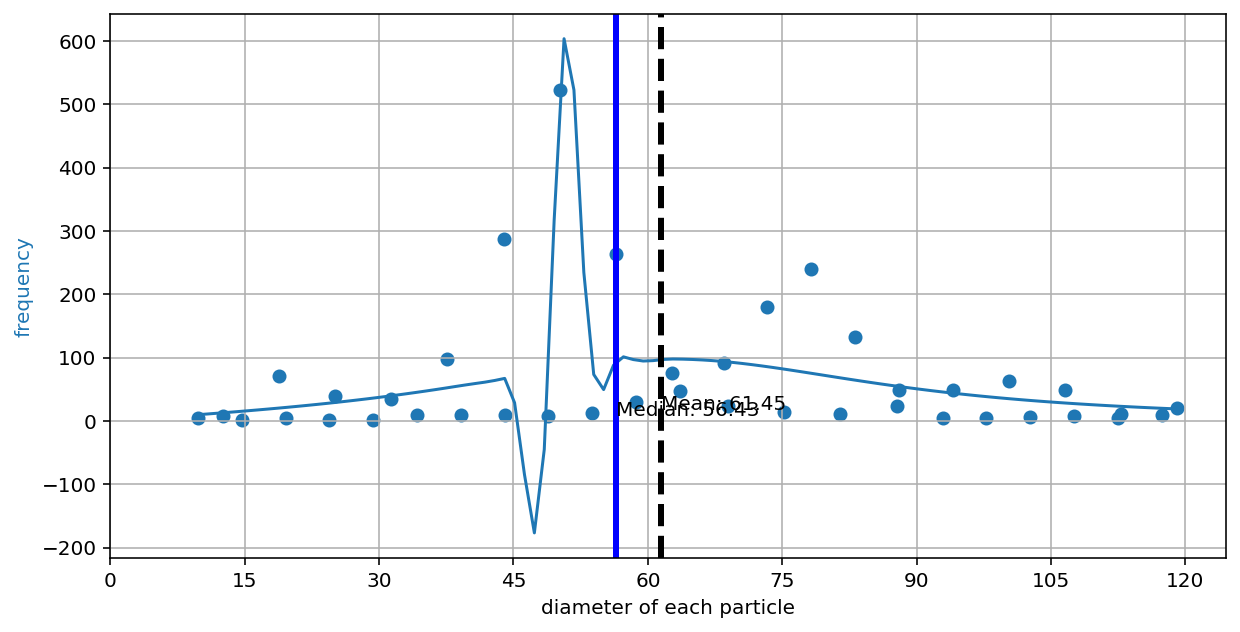

In [59]:
plot_lorent_fitting_func(NMResedual.x, residualX, residualY, diameter_frequency_1,'diameter of each particle','frequency')

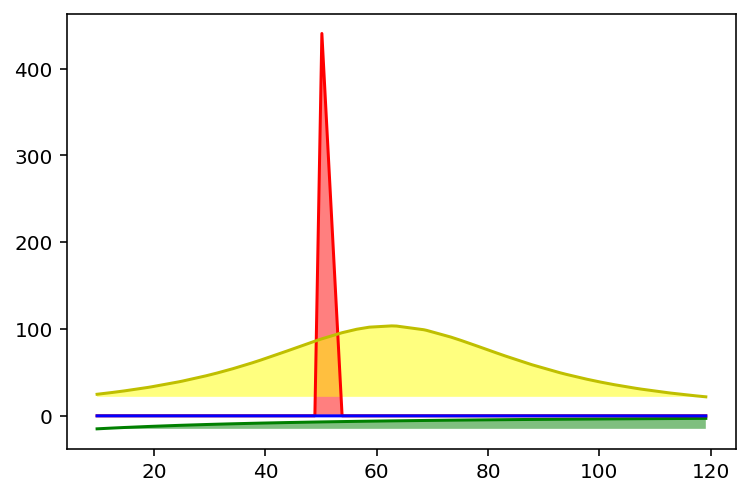

In [60]:
plot_lorent_fill_test(NMResedual.x)

In [61]:
NTResedual = minimize(lorent_leastsq, P0, method='Newton-CG',jac=lorent_jac, hess=lorent_hess , options={'maxiter':100,'disp': True})

         Current function value: 206854.725875
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 252
         Hessian evaluations: 100


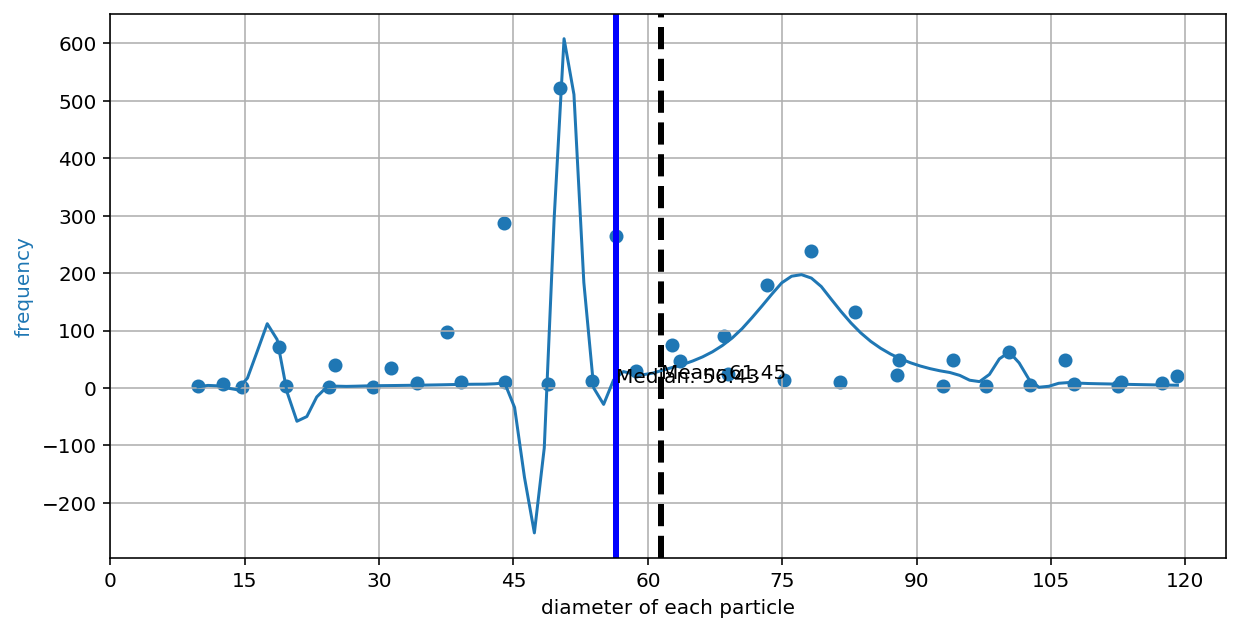

In [62]:
plot_lorent_fitting_func(NTResedual.x, residualX, residualY, diameter_frequency_1,'diameter of each particle','frequency')

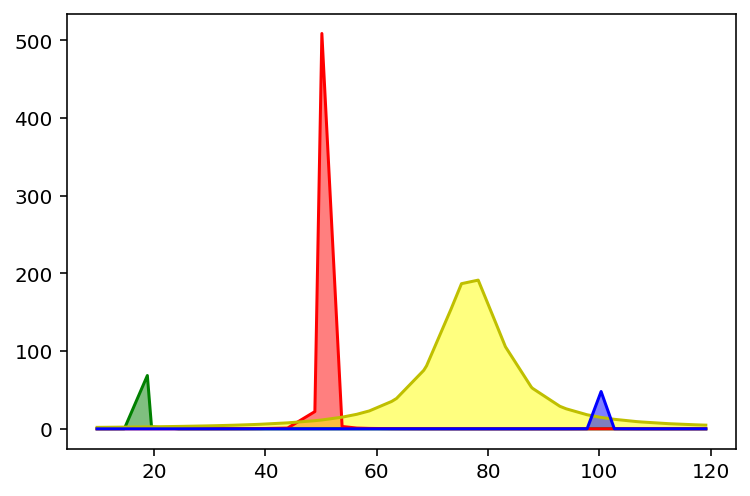

In [63]:
plot_lorent_fill_test(NTResedual.x)